In [1]:
import torch
from torch import nn
from torchvision import transforms
from torchvision.transforms.functional import to_pil_image
from torch.utils.data import DataLoader
from torchvision.datasets import CelebA
import matplotlib.pyplot as plt

from utils.image import *
from utils.io import *
from modules.conv2d_resblock import Conv2DResBlock

model_path = "iif_weights.pth"


In [2]:
class IIF(nn.Module):
    def __init__(self, dims=3, channels=128, blocks=8):
        super().__init__()

        self.dims = dims

        self.encoder = nn.Sequential(
            nn.Conv2d(self.dims, channels, 9, 1, 4),
            Conv2DResBlock(channels, channels, 5, 1, 2),
            Conv2DResBlock(channels, channels, 5, 1, 2),
            Conv2DResBlock(channels, channels, 5, 1, 2),
            Conv2DResBlock(channels, channels, 5, 1, 2),
            nn.Conv2d(channels, self.dims, 1, 1, 0),
        )

        self.decoder = nn.Sequential(
            nn.Linear(2 + 32 * 32 * 3, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 3),
        )

    def _sample_latent(self, Z, x):
        z = Z
        return z

    def forward(self, image, mask, x):
        Z = self.encoder(image.unsqueeze(0))
        Z *= mask
        z = self._sample_latent(Z, x)
        # Z: 3, 32, 32
        # x: n, 2

        z = z.flatten()
        # z: 3072

        decoder_input = torch.hstack((x, z.unsqueeze(0).repeat(x.shape[0], 1)))
        s = self.decoder(decoder_input)

        return s


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset = CelebA(
    "data",
    "train",
    download=False,
    transform=transforms.Compose([transforms.ToTensor(), transforms.Resize((32, 32))]),
)
dataloader = DataLoader(dataset, 1, shuffle=True, num_workers=4)


In [4]:
model = IIF().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)


In [5]:
def to_coords(image: torch.Tensor, mask: torch.Tensor):
    coords = mask[0].nonzero(as_tuple=True)
    return image[:, coords[0], coords[1]].T, mask[0].nonzero()


model.train()

for epoch in range(100):
    print(f"epoch {epoch}")
    
    for i, (images, _) in enumerate(dataloader):
        images = images.to(device)[0]
        masked, mask = mask_random(images, 0.5)
        
        s, x = to_coords(images, mask.logical_not())

        # s: (n, 3)
        # x: (n, 2)

        optimizer.zero_grad()
        s_pred = model(masked, mask, x)

        loss = ((s - s_pred) ** 2).mean()
        loss.backward()
        optimizer.step()

        if i % 10000 == 0:
            print(f"iteration {i} - loss {loss.item()}")

    torch.save(model.state_dict(), model_path)
    

epoch 0
iteration 0 - loss 0.14331085979938507


KeyboardInterrupt: 

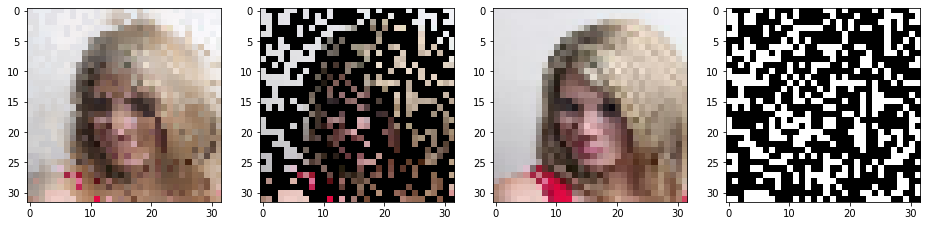

In [9]:
model = IIF().to(device)
model.load_state_dict(torch.load(model_path))
model.eval()


def from_coords(shape, x, s):
    image = torch.zeros(shape, device=x.device)
    image[:, x.T[0], x.T[1]] = s.T

    return image

images, _ = next(iter(dataloader))
images = images.to(device)[0]

masked, mask = mask_random(images, 0.4)
s, x = to_coords(masked, mask.logical_not())
s_pred = model(masked, mask, x)

plt.figure(figsize=(16,4))

plt.subplot(141)
plt.imshow(
    to_pil_image(from_coords((3, 32, 32), x, s_pred) + images * mask)
)
plt.subplot(142)
plt.imshow(to_pil_image(masked))

plt.subplot(143)
plt.imshow(to_pil_image(images))

plt.subplot(144)
plt.imshow(to_pil_image(mask))

plt.show()
